In [1]:
%matplotlib widget
import numpy as np
import json, glob
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools import timing_tool
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

### Choose the json file:

In [2]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [6]:
quantile_band = 0.5

TT1 = TT_PSEN119
TT2 = TT_PSEN126

channel_delay_motor = channel_delay_topas

timezero_mm = 40.228033

targetM2 = 'YAG'
px2fsM2 = 1.8692375 ## calibration from 17.10.2021


targetM1 = 'babyYAG'
px2fsM1 = 1.833608 ## calibration from 17.10.2021, white light different grating


#filterTimeM1 = 2048
#filterAmpM1 = 0
########################################
#YAG_scan_two_TT(json_file, TT1, TT2, channel_delay_motor, timezero_mm, quantile, 
#                    target_1, calibration_1, target_2, calibration_2,
#                    filterTime_1=2000, filterAmp_1=0, filterTime_2=2000, filterAmp_2=0):
########################################


Delay_fs_stage, Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan, Izero_scan, Amplitude_M2, Amplitude_M1,_ = \
YAG_scan_two_TT(fc.selected, TT1, TT2, channel_delay_motor, timezero_mm, quantile_band, targetM2, px2fsM2, targetM1, px2fsM1)

#Delays_corr_M2 -= Delay_fs
#Delays_corr_M1 -= Delay_fs

pp_uncorrected = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: scan.json
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 447 / 501 -> 11% loss ▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     447 / 501 -> 11% loss ▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 447 / 501 -> 11% loss
complete channels: 5 / 7 -> 29% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 211 pump and 211 unpump shots
File recorded at 2022-03-17 16:31:59.790084
/sf/alvra/data/p197

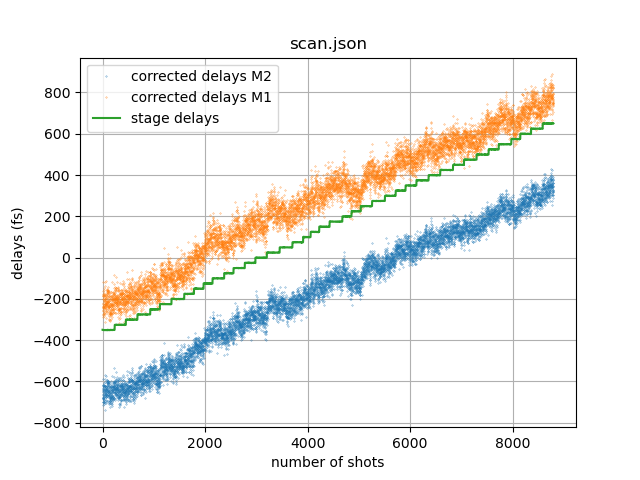

In [7]:
plt.figure()
plt.title(fc.selected_filename)

plt.plot(Delays_corr_M2, '.', ms=0.5, label = 'corrected delays M2')
plt.plot(Delays_corr_M1, '.', ms=0.5, label = 'corrected delays M1')
plt.plot(Delay_fs, label = 'stage delays')
   
plt.legend(loc='best')
plt.xlabel('number of shots')
plt.ylabel('delays (fs)')

plt.grid()
plt.show()

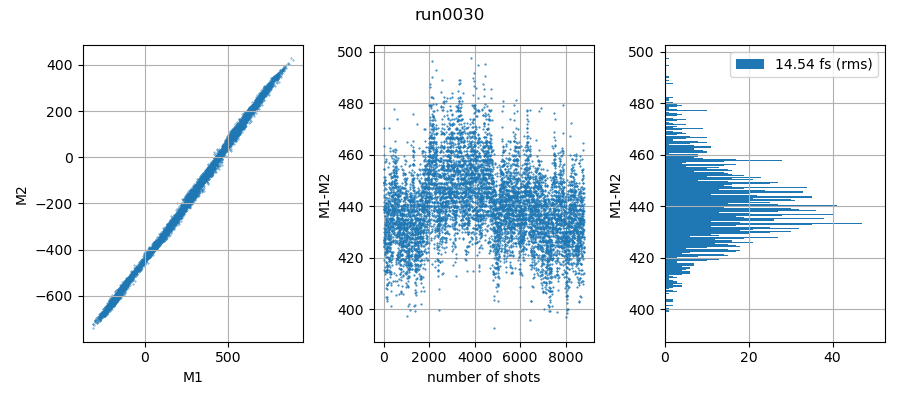

In [17]:
plt.figure(figsize=(9,4))
plt.suptitle(fc.selected.split('/')[-3])

plt.subplot(131)
plt.scatter(Delays_corr_M1, Delays_corr_M2, s=0.1)
plt.xlabel('M1')
plt.ylabel('M2')
plt.grid()

plt.subplot(132)
plt.plot(Delays_corr_M1 - Delays_corr_M2, '.', ms=1)
plt.xlabel('number of shots')
plt.ylabel('M1-M2')
#plt.ylim(0,250)
plt.grid()

plt.subplot(133)
plt.hist(Delays_corr_M1 - Delays_corr_M2, bins= 1000, orientation=u'horizontal', label = '{:.2f} fs (rms)'.format(np.std(Delays_corr_M1 - Delays_corr_M2)))
plt.legend(loc='best')
#plt.ylim(0,250)
plt.ylabel('M1-M2')
plt.grid()

plt.tight_layout()
plt.show()

ValueError: x and y must have the same length.

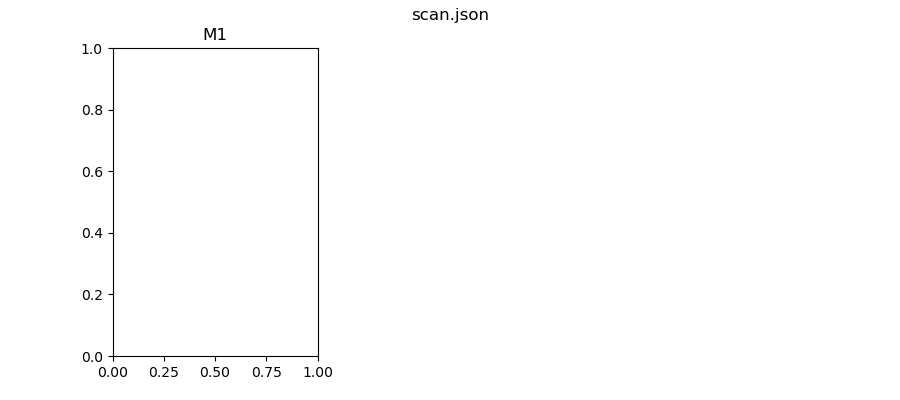

In [10]:
plt.figure(figsize = (9,4))
plt.suptitle (fc.selected_filename)

plt.subplot(131)
plt.title('M1')
plt.scatter(Amplitude_M1, Izero_scan, label = 'c={}'.format(pearsonr(Amplitude_M1, Izero_scan)[0]), s =0.5)
plt.legend(loc='best')
plt.xlabel('M1 amplitude')
plt.ylabel('Izero117')
plt.grid()

plt.subplot(132)
plt.title('M2')
plt.scatter(Amplitude_M2, Izero_scan, label = 'c={}'.format(pearsonr(Amplitude_M2, Izero_scan)[0]), s =0.5)
plt.legend(loc='best')
plt.xlabel('M2 amplitudes')
plt.ylabel('Izero117')
plt.grid()

plt.subplot(133)
plt.title('M1 vs M2')
plt.scatter(Amplitude_M1, Amplitude_M2, label = 'c={}'.format(pearsonr(Amplitude_M1, Amplitude_M2)[0]), s =0.5)
plt.legend(loc='best')
plt.xlabel('M1 amplitudes')
plt.ylabel('M2 amplitudes')
plt.grid()

plt.tight_layout()
plt.show()

## Re-bin the data with chosen binsize

In [359]:
binsize = 2 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

(7672,) (7672,) (7672,)


## Choose fit function

In [361]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
# fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
# fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
pp_TT_M2 =  pp_TT_M2[index_M2]

index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))
Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
pp_TT_M1 =  pp_TT_M1[index_M1]

## Do the fit for the first TT

In [362]:
fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

# fit.p0 =[272, 0.03, 100, 0.01, 200, 0, 0.05]

fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting

t0_fs_M2 = fit.popt[0]
t0_mm_M2 = timezero_mm + fs2mm(t0_fs_M2, 0)
width_fs_M2 = fit.popt[2]
amplitude_M2 = fit.popt[1]

## Do the fit for the second TT

In [363]:
fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 54) # overwrite some values (index) if needed:

# fit.p0 =[272.02, 0.03, 100, 0.01, 200, 0, 0.05]

fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting

t0_fs_M1 = fit.popt[0]
t0_mm_M1 = timezero_mm + fs2mm(t0_fs_M1, 0)
width_fs_M1 = fit.popt[2]
amplitude_M1 = fit.popt[1] + fit.popt[3]
print (amplitude_M1)

0.22314212189107568


## Plot

<IPython.core.display.Javascript object>


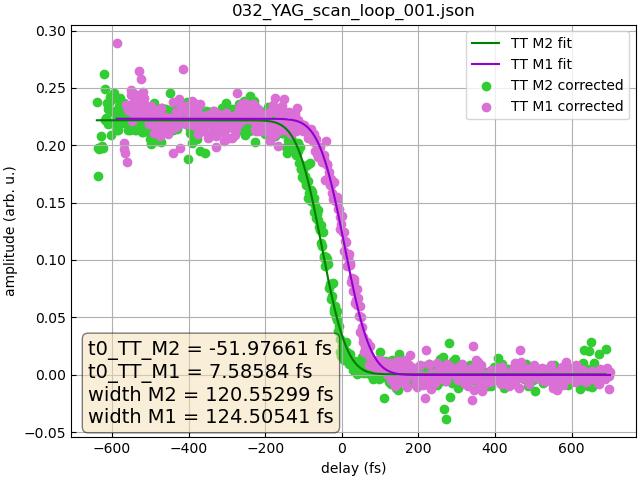

In [364]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')

#plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
#plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format((np.round(timezero_mm, 5))))
plt.scatter(Delay_fs_TT_M2, pp_TT_M2, color='limegreen', label = 'TT M2 corrected')
plt.scatter(Delay_fs_TT_M1, pp_TT_M1, color='orchid', label = 'TT M1 corrected')
plt.plot(Delay_fs_TT_M2, pp_fit_M2, color='green', label = 'TT M2 fit')
plt.plot(Delay_fs_TT_M1, pp_fit_M1, color='darkviolet', label = 'TT M1 fit')


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0_TT_M2 = {} fs'.format(np.round(t0_fs_M2, 5)),
                     r't0_TT_M1 = {} fs'.format(np.round(t0_fs_M1, 5)),
            r'width M2 = {} fs'.format(np.abs(np.round(width_fs_M2, decimals = 5))),
            r'width M1 = {} fs'.format(np.abs(np.round(width_fs_M1, decimals = 5)))))
plt.text(0.03, 0.035, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.grid()
plt.show()


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


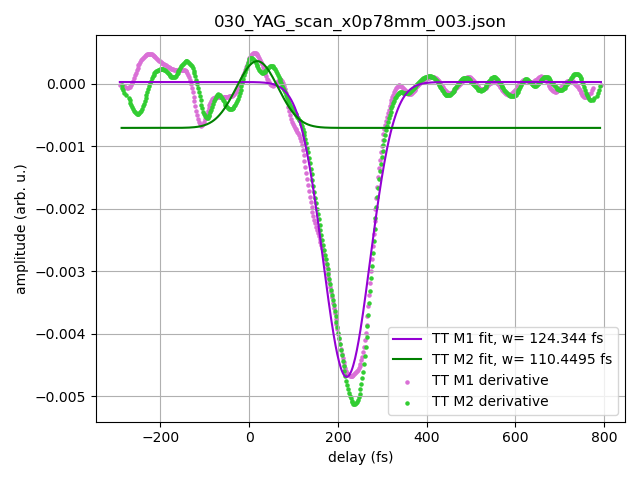

In [334]:
pp_TT_M1_derivative = gaussian_filter1d(pp_TT_M1, 8, order = 1)
pp_TT_M2_derivative = gaussian_filter1d(pp_TT_M2, 8, order = 1)

parameters_M1,extras = curve_fit(gaussian, Delay_fs_TT_M1, pp_TT_M1_derivative, \
                                 p0 = [pp_TT_M1_derivative.min(), 0, 200, 0])
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT_M2, pp_TT_M2_derivative, \
                                 p0 = [pp_TT_M2_derivative.min(), 0, -50, 0])


plt.figure()
plt.title(fc.selected_filename)
plt.scatter(Delay_fs_TT_M1, pp_TT_M1_derivative, color='orchid', label = 'TT M1 derivative', s = 5)
plt.plot(Delay_fs_TT_M1, gaussian(Delay_fs_TT_M1,*parameters_M1), color='darkviolet',\
         label = 'TT M1 fit, w= {} fs'.format(np.abs(np.round(parameters_M1[2],1)*2.355)))
plt.scatter(Delay_fs_TT_M2, pp_TT_M2_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT_M2, gaussian(Delay_fs_TT_M2,*parameters_M2), color='green', \
         label = 'TT M2 fit, w= {} fs'.format(np.abs(np.round(parameters_M2[2],1)*2.355)))

plt.legend(loc='best')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

#print ('width M1 = {}'.format(np.abs(parameters_M1[2])*2.355))
#print ('width M2 = {}'.format(np.abs(parameters_M2[2])*2.355))


# Loop over several runs

In [391]:
datafiles = []
datafiles1 = []
datafiles2 = []
datafiles3 = []
for file in glob('/sf/alvra/data/p19470/raw/scan_info/031*.json'):
    datafiles1.append(file)
datafiles1 = sorted(datafiles1, key = os.path.getmtime)
    
for file in glob('/sf/alvra/data/p19470/raw/scan_info/032*.json'):
    datafiles2.append(file)
datafiles2 = sorted(datafiles2, key = os.path.getmtime)

for file in glob('/sf/alvra/data/p19470/raw/scan_info/033*.json'):
    datafiles3.append(file)
datafiles3 = sorted(datafiles3, key = os.path.getmtime)


datafiles = datafiles1[:-1] + datafiles2[:-1] + datafiles3[:-4]
    
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles
patch

['/sf/alvra/data/p19470/raw/scan_info/031_YAG_scan_loop_001.json',
 '/sf/alvra/data/p19470/raw/scan_info/031_YAG_scan_loop_002.json',
 '/sf/alvra/data/p19470/raw/scan_info/031_YAG_scan_loop_003.json',
 '/sf/alvra/data/p19470/raw/scan_info/031_YAG_scan_loop_004.json',
 '/sf/alvra/data/p19470/raw/scan_info/031_YAG_scan_loop_005.json',
 '/sf/alvra/data/p19470/raw/scan_info/032_YAG_scan_loop_001.json',
 '/sf/alvra/data/p19470/raw/scan_info/032_YAG_scan_loop_002.json',
 '/sf/alvra/data/p19470/raw/scan_info/032_YAG_scan_loop_003.json',
 '/sf/alvra/data/p19470/raw/scan_info/032_YAG_scan_loop_004.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_001.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_002.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_003.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_004.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_005.json',
 '/sf/alvra/data/p19470/raw/scan_info/033_YAG_scan_loop_006.js

In [392]:
quantile_band = 0.5
binsize = 2
sigma_derivative = 10

channel_delay_motor = channel_delay_topas
#channel_delay_motor = channel_delay_global
timezero_mm = 225.38
#timezero_mm = 40.5708

targetM2 = 'YAG'
#px2fsM2 = 2.044
px2fsM2 = 1.91 ## calibration from 14.10.2021
px2fsM2 = 1.8 ## calibration from 15.10.2021
px2fsM2 = 1.92 ## calibration from 16.10.2021
px2fsM2 = 1.8692375 ## calibration from 17.10.2021

targetM1 = 'babyYAG'
#px2fsM1 = 1.957
px2fsM1 = 1.518 ## calibration from 14.10.2021, white light
px2fsM1 = 1.18 ## calibration from 15.10.2021, NOPA
px2fsM1 = 2.57 ## calibration from 16.10.2021, NOPA stretched
px2fsM1 = 1.833608 ## calibration from 17.10.2021, white light different grating

filterTimeM1 = 2000
filterAmpM1 = 0

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_M2_scan = []
t0_fs_M2_scan_der = []
width_fs_M2_scan = []
amplitude_M2_scan = []

t0_fs_M1_scan =[]
t0_fs_M1_scan_der = []
width_fs_M1_scan = []
amplitude_M1_scan = []

t0_fs_M1_scan_derivative =[]
t0_fs_M2_scan_derivative =[]

for json_file in patch:
    print (json_file)
    scan = SFScanInfo(json_file)
        
    Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan, Izero_scan, Amplitude_M1, Amplitude_M2 = \
    YAG_scan_two_TT(json_file, channel_delay_motor, timezero_mm, quantile_band, \
                    targetM2, px2fsM2, targetM1, px2fsM1, \
                    2000, 0, filterTimeM1, filterAmpM1)
    
    #Delays_corr_M2 -= Delay_fs
    #Delays_corr_M1 -= Delay_fs
    
    print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
    pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    #fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
    index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))

    Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
    Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
    pp_TT_M2 =  pp_TT_M2[index_M2]
    pp_TT_M1 =  pp_TT_M1[index_M1]
    
    ############################################################
    
    pp_TT_M1_derivative = gaussian_filter1d(pp_TT_M1, sigma_derivative, order = 1)
    t0_fs_M1_derivative = Delay_fs_TT_M1[np.argmax(-pp_TT_M1_derivative, axis = -1)]
    
    pp_TT_M2_derivative = gaussian_filter1d(pp_TT_M2, sigma_derivative, order = 1)
    t0_fs_M2_derivative = Delay_fs_TT_M2[np.argmax(-pp_TT_M2_derivative, axis = -1)]
    
    ############################################################

    fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed:
    #fit.p0 =[272.15, 0.03, 80, 0.001, 200, 0, 0.01] #parameters for heavyside2 fit (SiN)

    fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
    pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting
    
    t0_fs_M2 = fit.popt[0]
    width_fs_M2 = fit.popt[2]
    amplitude_M2 = fit.popt[1] + fit.popt[3]
    
    print('popt M2:  ', fit.popt)
    
    ############################################################
    
    fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 50) # overwrite some values (index) if needed:
    #fit.p0 =[272.15, 0.03, 80, 0.001, 200, 0, 0.01] #parameters for heavyside2 fit (SiN)

    fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
    pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting
    
    t0_fs_M1 = fit.popt[0]
    width_fs_M1 = fit.popt[2]
    amplitude_M1 = fit.popt[1] + fit.popt[3]

    print('popt M1:  ', fit.popt)
    
    ############################################################
    
    t0_fs_M2_scan.append(t0_fs_M2)
    t0_fs_M2_scan_derivative.append(t0_fs_M2_derivative)
    width_fs_M2_scan.append(width_fs_M2)
    amplitude_M2_scan.append(amplitude_M2)
    t0_fs_M1_scan.append(t0_fs_M1)
    t0_fs_M1_scan_derivative.append(t0_fs_M1_derivative)
    width_fs_M1_scan.append(width_fs_M1)
    amplitude_M1_scan.append(amplitude_M1)
    

Processing: 033_YAG_scan_loop_060.json
Step 49 of 49: Processing run_025027

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     502 / 502 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     443 / 502 -> 12% loss ▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 445 / 502 -> 11% loss ▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     445 / 502 -> 11% loss ▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY                   502 / 502 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS                  502 / 502 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               502 / 502 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               502 / 502 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 404 / 502 -> 20% loss
complete channels: 5 / 8 -> 38% incomplete

--------------------------------------------------------------------------------

Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


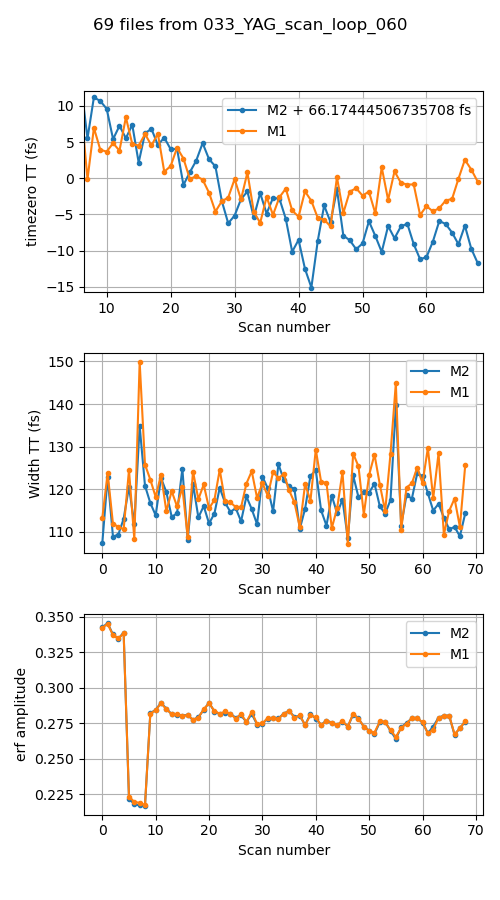

In [395]:
offset = t0_fs_M1_scan[0] - t0_fs_M2_scan[0]
#offset = 0

plt.figure(figsize = (5,9))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-1].split('.')[0]))

plt.subplot(311)
plt.plot(np.asarray(t0_fs_M2_scan)+offset, marker='.', label='M2 + {} fs'.format(offset))
plt.plot(t0_fs_M1_scan, marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel('Scan number')
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(312)
plt.plot(np.abs(width_fs_M2_scan), marker='.', label='M2')
plt.plot(np.abs(width_fs_M1_scan), marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel("Scan number")
plt.ylabel('Width TT (fs)')
plt.grid()

plt.subplot(313)
plt.plot(np.abs(amplitude_M2_scan), marker='.', label='M2')
plt.plot(np.abs(amplitude_M1_scan), marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel("Scan number")
plt.ylabel('erf amplitude')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


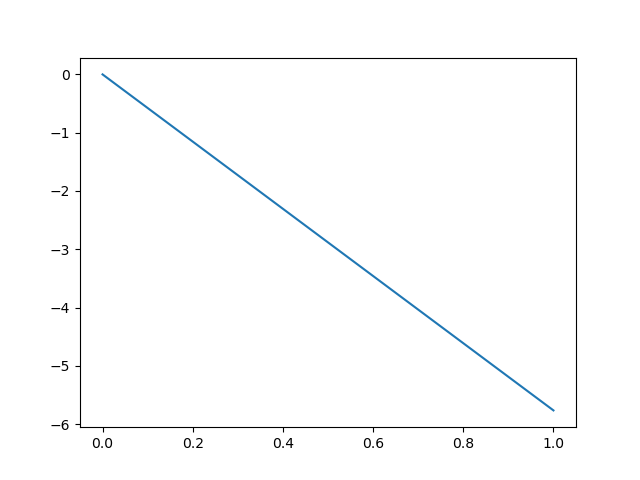

In [213]:
plt.figure()
plt.plot(np.asarray(t0_fs_M2_scan)-t0_fs_M1_scan+offset)
plt.show()

In [56]:
np.abs(width_fs_M2_scan)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([48.31564754, 45.35459989, 46.38803604, 48.82467354, 41.72229399,
       51.92472967, 48.20162697, 43.38149879, 49.55902355, 49.24818079])

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


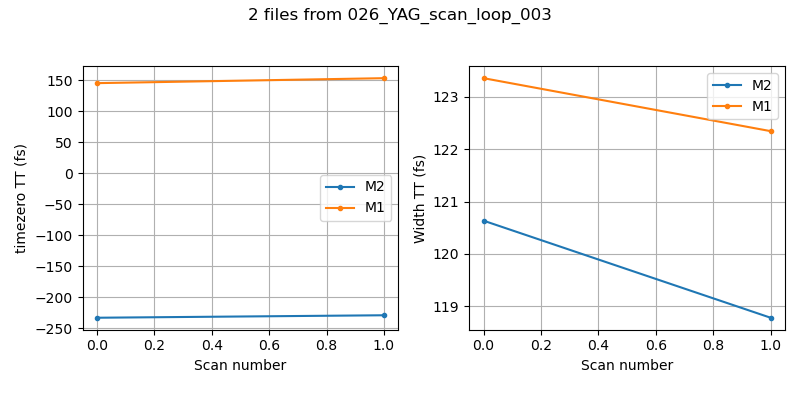

In [214]:
plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-1].split('.')[0]))

plt.subplot(121)
plt.plot(np.asarray(t0_fs_M2_scan_derivative)-200, marker='.', label='M2')
plt.plot(t0_fs_M1_scan_derivative, marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel('Scan number')
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_M2_scan, marker='.', label='M2')
plt.plot(width_fs_M1_scan, marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel("Scan number")
plt.ylabel('Width TT (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Timing tool traces & statistics

In [151]:
fc = FileChooser('/sf/alvra/data/p19470/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19470/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [152]:
targetM2 = 'YAG'
#px2fsM2 = 2.044
#px2fsM2 = 1.91 ## calibration from 14.10.2021
px2fsM2 = 1.8 ## calibration from 15.10.2021

targetM1 = 'babyYAG'
#px2fsM1 = 1.957
px2fsM1 = 1.518 ## calibration from 14.10.2021, white light
px2fsM1 = 1.18 ## calibration from 15.10.2021, NOPA

arrTimes_M2, arrTimesAmp_M2, arrTimes_M2_scan, arrTimesAmp_M2_scan, peaktraces_M2,\
arrTimes_M1, arrTimesAmp_M1, arrTimes_M1_scan, arrTimesAmp_M1_scan, peaktraces_M1 = \
Two_TT_statistics_scan(fc.selected,  targetM2, px2fsM2, targetM1, px2fsM1)


Processing: 005_SiN_scan_short_NOPA__fast_loop_001.json
Step 16 of 16: Processing run_013738

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     1001 / 1001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile      929 / 1001 ->  7% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile  897 / 1001 -> 10% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile      897 / 1001 -> 10% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 832 / 1001 -> 17% loss
complete channels: 1 / 4 -> 75% incomplete

--------------------------------------------------------------------------------

(832,) (832,)
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz
File recorded at 2021-10-16 11:28:37.702809
/sf/alvra/data/p19470/scratch/2021-10-13-14:22-psen-background.txt
/sf/alvra/data/p19470/scratch/2021-10-13-14:22-psen-peak-background.txt


<IPython.core.display.Javascript object>


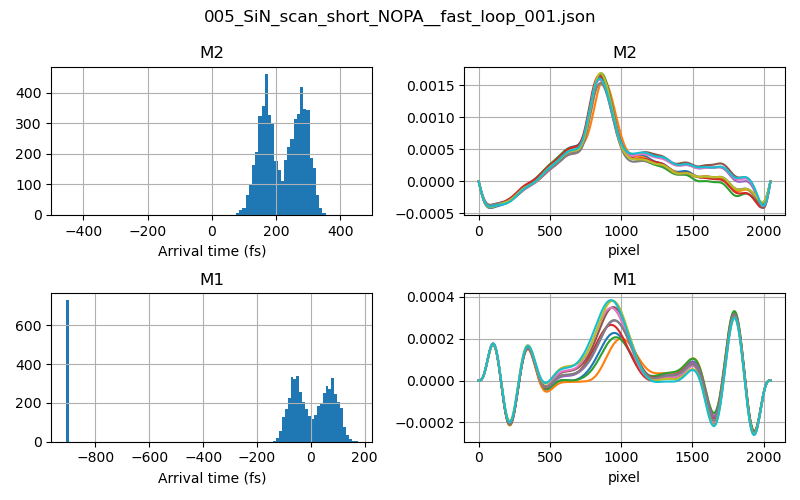

M2
Statistics on all (5614,) shots of the scan
Offset compared to pixel 1048 is 222.49942999643744 fs
Jitter, i.e. width (std) of the histogram 61.406430738550895 fs
--------------------------------------------------------------
Statistics on (355,) shots of the last step of the scan
Offset compared to pixel 1048 is 295.0225352112676 fs
Jitter, i.e. width (std) of the histogram 18.313050816082562 fs
**************************************************************
M1
Statistics on all (5614,) shots of the scan
Offset compared to pixel 1048 is -110.61312433202708 fs
Jitter, i.e. width (std) of the histogram 314.41589235264735 fs
--------------------------------------------------------------
Statistics on (355,) shots of the last step of the scan
Offset compared to pixel 1048 is -285.57329577464793 fs
Jitter, i.e. width (std) of the histogram 482.474199702069 fs


In [153]:
plt.figure(figsize = (8,5))
plt.suptitle (fc.selected_filename)

plt.subplot(221)
plt.title('M2')
plt.hist(arrTimes_M2_scan, bins=30)
plt.grid()
plt.xlim(-500,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(222)
plt.title('M2')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M2[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.subplot(223)
plt.title('M1')
plt.hist(arrTimes_M1_scan, bins=100)
plt.grid()
#plt.xlim(-1000,0)
plt.xlabel('Arrival time (fs)')

plt.subplot(224)
plt.title('M1')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M1[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.tight_layout()
plt.show()

print("M2")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M2_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M2)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2)))
print("**************************************************************")
print("M1")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M1_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M1)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1)))
